In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import dlib
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from retinaface.commons.postprocess import rotate_facial_area
from retinaface import RetinaFace

In [292]:
def normal_to_pixel(x, y, w, h, invert = False):
    if invert:
        return list(np.array((x, y)) / np.array((w, h)))
    return list((np.array((x, y)) * np.array((w, h))).astype(int))

In [354]:
def get_angle_from_eyes(left_eye, right_eye, degrees = True):
    cos_angle = left_eye.dot(right_eye) / (np.linalg.norm(left_eye, 2) * np.linalg.norm(right_eye, 2))
    
    direction = 1
    if right_eye[1] > left_eye[1]:
        direction = -1

    angle = np.arccos(cos_angle)
    if degrees:
        angle = np.rad2deg(angle)
        
    return angle, direction

In [294]:
def rotate_from_angle(image, center, angle, direction, degrees = True):
    if not degrees:
        angle = np.rad2deg(angle)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle * direction, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    return rotated_image

In [65]:
def dlib_(image_path):
    
    return

In [66]:
def retinaface_align(image_path):
    
    return

In [67]:
def dlib_crop():
    return

In [ ]:
def get_retinaface_preds(image):
    faces = RetinaFace.detect_faces(img_path = image_path)
    
    return faces

In [ ]:
def get_dlib_faces(image):
    # Instantiate a dlib face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor('./pretrained_models/shape_predictor_5_face_landmarks.dat')
    
    # Get faces from image
    detections = detector(image, 0)
    faces = dlib.full_object_detections()
    for detection in detections:
        faces.append(shape_predictor(image, detection))
        
    return faces

In [ ]:
def get_mediapipe_mesh(image):
    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(static_image_mode = True,
                               max_num_faces = 1,
                               refine_landmarks = True) as face_mesh:
        results = face_mesh.process(img[:,:,::-1])
    
    return results

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(static_image_mode = True,
                           max_num_faces = 1,
                           refine_landmarks = True) as face_mesh:
    results = face_mesh.process(img[:,:,::-1])

In [351]:
def mediapipe_crop(image, mp_results):
    left_iris = [474,475, 476, 477]
    right_iris = [469, 470, 471, 472]
    landmarks = [left_iris, right_iris]

    pixels = []
    for eye in landmarks:
        eye_pixels = []
        for num in eye:
            landmark = results.multi_face_landmarks[0].landmark[num]
            coords = normal_to_pixel(float(landmark.x), float(landmark.y),
                                     img_with_pixel.shape[1], img_with_pixel.shape[0])
            eye_pixels.append(np.array(coords))
        pixels.append(np.array(eye_pixels))

    eye_centers = [(np.sum(eye, axis = 0) / len(eye)).astype(int) for eye in pixels]
    
    angle, direction = get_angle_from_eyes(eye_centers[0], eye_centers[1])

    rotated_image = rotate_from_angle(image, tuple(np.array(image.shape[1::-1]) / 2), angle, direction)
    
    return rotated_image

In [69]:
def retinaface_crop():
    return

In [84]:
def align_image(image_path):
    """
    Aligns an image so that the eyes of a detected face are level.
    Args:
        image_path (str or numpy array): path to image or numpy array representation of image
    Returns:
        
    """
    
    if type(image_path) == str:
        image = cv2.imread(image_path)
    else:
        image = image_path
    
    # Instantiate a dlib face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor('./pretrained_models/shape_predictor_5_face_landmarks.dat')
    
    # Get faces from image
    detections = detector(image, 0)
    faces = dlib.full_object_detections()
    for detection in detections:
        faces.append(shape_predictor(image, detection))
    
    # If dlib fails to find faces, transition to RetinaFace
    if len(faces) == 0:
        print("dlib failed to find any faces, testing RetinaFace.")
        # Gets facial information from image
        # RetinaFace.extract_faces is not used as it uses upscaling even when upscaling is set to False
        face_1 = RetinaFace.detect_faces(img_path = image_path)['face_1']
        right_eye = np.array(face_1['landmarks']['right_eye'])
        left_eye = np.array(face_1['landmarks']['left_eye'])
        
        cos_angle = left_eye.dot(right_eye) / (np.linalg.norm(right_eye, 2) * np.linalg.norm(left_eye, 2))
        direction = 1
        if right_eye[1] > left_eye[1]:
            direction = -1
        
        angle = np.rad2deg(np.arccos(cos_angle))
        
        
        rot_matrix = cv2.getRotationMatrix2D(tuple(np.array(img.shape[1::-1]) / 2), direction * angle, 1)
        rotated_image = cv2.warpAffine(img, rot_matrix, img.shape[1::-1])
        
        x_1, y_1, x_2, y_2 = face_1['facial_area']
        
        rotated_facial_area = rotate_facial_area(face_1['facial_area'], angle, direction, img.shape[1::-1])
        
        return rotated_image, rotated_facial_area
    
    #
    chip_details = dlib.get_face_chip_details(faces)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    
    # If there are multiple faces found, choose the image closest to the center of the picture
    face_centers = [(k.rect.center().x, k.rect.center().y) for k in chip_details]
    chip_index = np.argmin(np.sum(np.abs(np.array(image_center) - np.array(face_centers)), axis = 1))
    
    angle = chip_details[chip_index].angle
    
    rotation_matrix = cv2.getRotationMatrix2D(tuple(face_centers[chip_index]), np.rad2deg(angle), 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    return rotated_image, chip_details[chip_index].rect

In [71]:
def crop_image(image, dlib_rect = None):
    # Creating a FaceLandmarker object.
    base_options = python.BaseOptions(model_asset_path = './pretrained_models/face_landmarker.task');
    options = vision.FaceLandmarkerOptions(base_options = base_options, num_faces = 1);
    detector = vision.FaceLandmarker.create_from_options(options);

    # Convert the image to MediaPipe format.
    mp_image = mp.Image(image_format = mp.ImageFormat.SRGB, data = image);

    # Detect face landmarks.
    detection_result = detector.detect(mp_image);
    
    if len(detection_result.face_landmarks) != 0:
        # Calculate the bounding box for the face based off of the minimum and maximum coordinates in found landmarks.
        # Landmarks are in normalized coordinates, so must be converted back to pixel coordinates.
        min_x = int(np.round(min([k.x for k in detection_result.face_landmarks[0]]) * image.shape[1]))
        max_x = int(np.round(max([k.x for k in detection_result.face_landmarks[0]]) * image.shape[1]))
        min_y = int(np.round(min([k.y for k in detection_result.face_landmarks[0]]) * image.shape[0]))
        max_y = int(np.round(max([k.y for k in detection_result.face_landmarks[0]]) * image.shape[0]))

        cropped_image = image[min_y:max_y, min_x:max_x, :]
    else:
        x_l, x_r, y_t, y_b = (int(np.round(dlib_rect.left())), int(np.round(dlib_rect.right())),
                              int(np.round(dlib_rect.bottom())), int(np.round(dlib_rect.top())))
        cropped_image = image[y_b:y_t, x_l:x_r, :]
    
#     rotated_facial_area = rotate_facial_area(face_1['facial_area'], angle, direction, img.shape[1::-1])
#     rot_x1, rot_y1, rot_x2, rot_y2 = rotated_facial_area
#     crop_face = rot_img[rot_y1:rot_y2, rot_x1:rot_x2, :]
    
    
    return cropped_image

In [72]:
def pad_image(image, end_dim = (250, 250), color = (0, 0, 0)):
    old_height, old_width, channels = image.shape
    new_height, new_width = end_dim
    
    x_center = (new_width - old_width) // 2
    y_center = (new_height - old_height) // 2
    
    y_top = y_center + old_height
    x_right = x_center + old_width
    
    padded_image = np.full((new_height, new_width, channels), color, dtype = np.uint8)
    
    padded_image[y_center:y_top, x_center:x_right] = image
    
    return padded_image

In [73]:
def preprocess_image(image, end_dim = (250, 250), color = (0, 0, 0), backends = ['mediapipe', 'dlib', 'retinaface']):
    aligned_image, chip_rect = align_image(image)
    cropped_image = crop_image(aligned_image, dlib_rect = chip_rect)
    padded_image = pad_image(cropped_image, end_dim = end_dim, color = color)
    
    return padded_image

In [74]:
raw_path = './data/raw'
preprocessed_path = './data/preprocessed'
folder_names = ['train', 'test']

In [10]:
for folder in folder_names:
    image_names = os.listdir(os.path.join(raw_path, folder))
    for i, image_name in enumerate(image_names):
        print(f'Processing image {image_name}. {i + 1}/{len(image_names)}')
        image = cv2.imread(os.path.join(raw_path, folder, image_name))
        processed_image = preprocess_image(image)
        dest_path = os.path.join(preprocessed_path, folder, image_name)
        cv2.imwrite(dest_path, processed_image)
        print(f'Image {image_name} successfully processed and written to {dest_path}.')

Processing image Aaron_Guiel_0001.jpg. 1/3708


libEGL warning: DRI2: failed to authenticate
I0000 00:00:1720572432.749845   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572432.753993   17006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572432.754896   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Image Aaron_Guiel_0001.jpg successfully processed and written to ./data/preprocessed/train/Aaron_Guiel_0001.jpg.
Processing image Aaron_Tippin_0001.jpg. 2/3708


I0000 00:00:1720572433.161666   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572433.168061   17011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572433.168742   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aaron_Tippin_0001.jpg successfully processed and written to ./data/preprocessed/train/Aaron_Tippin_0001.jpg.
Processing image Abba_Eban_0001.jpg. 3/3708


I0000 00:00:1720572433.587793   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572433.592489   17016 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572433.593220   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abba_Eban_0001.jpg successfully processed and written to ./data/preprocessed/train/Abba_Eban_0001.jpg.
Processing image Abdulaziz_Kamilov_0001.jpg. 4/3708


I0000 00:00:1720572433.983792   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572433.988642   17021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572433.989584   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdulaziz_Kamilov_0001.jpg successfully processed and written to ./data/preprocessed/train/Abdulaziz_Kamilov_0001.jpg.
Processing image Abdullah_Gul_0001.jpg. 5/3708


I0000 00:00:1720572434.353254   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572434.356641   17026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572434.357316   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0001.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0001.jpg.
Processing image Abdullah_Gul_0002.jpg. 6/3708


I0000 00:00:1720572434.751751   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572434.756918   17031 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572434.757608   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0002.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0002.jpg.
Processing image Abdullah_Gul_0003.jpg. 7/3708


I0000 00:00:1720572435.490413   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572435.495043   17036 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572435.496175   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0003.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0003.jpg.
Processing image Abdullah_Gul_0004.jpg. 8/3708


I0000 00:00:1720572435.968948   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572435.974037   17041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572435.975002   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0004.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0004.jpg.
Processing image Abdullah_Gul_0005.jpg. 9/3708


I0000 00:00:1720572436.388042   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572436.391251   17046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572436.391862   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0005.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0005.jpg.
Processing image Abdullah_Gul_0006.jpg. 10/3708


I0000 00:00:1720572436.789406   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572436.793469   17051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572436.794234   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0006.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0006.jpg.
Processing image Abdullah_Gul_0007.jpg. 11/3708


I0000 00:00:1720572437.225498   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572437.232664   17056 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572437.233606   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0007.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0007.jpg.
Processing image Abdullah_Gul_0008.jpg. 12/3708


I0000 00:00:1720572437.639833   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572437.645854   17061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572437.646802   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0008.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0008.jpg.
Processing image Abdullah_Gul_0009.jpg. 13/3708


I0000 00:00:1720572438.083146   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572438.088248   17066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572438.088795   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0009.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0009.jpg.
Processing image Abdullah_Gul_0010.jpg. 14/3708


I0000 00:00:1720572438.484549   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572438.488726   17071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572438.489416   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0010.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0010.jpg.
Processing image Abdullah_Gul_0011.jpg. 15/3708


I0000 00:00:1720572438.888878   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572438.894329   17076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572438.895000   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0011.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0011.jpg.
Processing image Abdullah_Gul_0012.jpg. 16/3708


I0000 00:00:1720572439.372436   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572439.379182   17081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572439.379926   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0012.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0012.jpg.
Processing image Abdullah_Gul_0013.jpg. 17/3708


I0000 00:00:1720572439.784247   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572439.787491   17086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572439.788162   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0013.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0013.jpg.
Processing image Abdullah_Gul_0014.jpg. 18/3708


I0000 00:00:1720572440.183956   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572440.190080   17091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572440.191033   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0014.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0014.jpg.
Processing image Abdullah_Gul_0015.jpg. 19/3708


I0000 00:00:1720572440.621348   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572440.624765   17096 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572440.625361   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0015.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0015.jpg.
Processing image Abdullah_Gul_0016.jpg. 20/3708


I0000 00:00:1720572441.020961   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572441.029087   17101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572441.030296   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0016.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0016.jpg.
Processing image Abdullah_Gul_0017.jpg. 21/3708


I0000 00:00:1720572441.560794   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572441.564679   17106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572441.565427   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0017.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0017.jpg.
Processing image Abdullah_Gul_0018.jpg. 22/3708


I0000 00:00:1720572441.937489   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572441.942682   17111 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572441.943587   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0018.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0018.jpg.
Processing image Abdullah_Gul_0019.jpg. 23/3708


I0000 00:00:1720572442.332882   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572442.336965   17116 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572442.337615   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullah_Gul_0019.jpg successfully processed and written to ./data/preprocessed/train/Abdullah_Gul_0019.jpg.
Processing image Abdullatif_Sener_0001.jpg. 24/3708


I0000 00:00:1720572442.690005   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572442.693992   17121 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572442.694570   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullatif_Sener_0001.jpg successfully processed and written to ./data/preprocessed/train/Abdullatif_Sener_0001.jpg.
Processing image Abdullatif_Sener_0002.jpg. 25/3708


I0000 00:00:1720572443.064804   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572443.068272   17126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572443.069199   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdullatif_Sener_0002.jpg successfully processed and written to ./data/preprocessed/train/Abdullatif_Sener_0002.jpg.
Processing image Abdul_Majeed_Shobokshi_0001.jpg. 26/3708


I0000 00:00:1720572443.464529   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572443.468548   17131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572443.469332   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abdul_Majeed_Shobokshi_0001.jpg successfully processed and written to ./data/preprocessed/train/Abdul_Majeed_Shobokshi_0001.jpg.
Processing image Abel_Aguilar_0001.jpg. 27/3708


I0000 00:00:1720572443.857195   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572443.864186   17136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572443.864959   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abel_Aguilar_0001.jpg successfully processed and written to ./data/preprocessed/train/Abel_Aguilar_0001.jpg.
Processing image Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg. 28/3708


I0000 00:00:1720572444.263534   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572444.266758   17141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572444.267413   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg successfully processed and written to ./data/preprocessed/train/Abid_Hamid_Mahmud_Al-Tikriti_0001.jpg.
Processing image Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg. 29/3708


I0000 00:00:1720572444.642061   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572444.645402   17146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572444.646143   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg successfully processed and written to ./data/preprocessed/train/Abid_Hamid_Mahmud_Al-Tikriti_0002.jpg.
Processing image Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg. 30/3708


I0000 00:00:1720572445.063410   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572445.066572   17151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572445.067445   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg successfully processed and written to ./data/preprocessed/train/Abid_Hamid_Mahmud_Al-Tikriti_0003.jpg.
Processing image Adam_Ant_0001.jpg. 31/3708


I0000 00:00:1720572445.475960   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572445.479993   17156 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572445.481134   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adam_Ant_0001.jpg successfully processed and written to ./data/preprocessed/train/Adam_Ant_0001.jpg.
Processing image Adam_Kennedy_0001.jpg. 32/3708


I0000 00:00:1720572446.103783   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572446.109109   17161 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572446.110026   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adam_Kennedy_0001.jpg successfully processed and written to ./data/preprocessed/train/Adam_Kennedy_0001.jpg.
Processing image Adel_Al-Jubeir_0001.jpg. 33/3708


I0000 00:00:1720572446.528773   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572446.532091   17166 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572446.532744   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adel_Al-Jubeir_0001.jpg successfully processed and written to ./data/preprocessed/train/Adel_Al-Jubeir_0001.jpg.
Processing image Adel_Al-Jubeir_0002.jpg. 34/3708


I0000 00:00:1720572446.942993   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572446.948778   17171 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572446.949497   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adel_Al-Jubeir_0002.jpg successfully processed and written to ./data/preprocessed/train/Adel_Al-Jubeir_0002.jpg.
Processing image Adel_Al-Jubeir_0003.jpg. 35/3708


I0000 00:00:1720572447.331971   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572447.335268   17176 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572447.335899   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adel_Al-Jubeir_0003.jpg successfully processed and written to ./data/preprocessed/train/Adel_Al-Jubeir_0003.jpg.
Processing image Adriana_Lima_0001.jpg. 36/3708


I0000 00:00:1720572447.720863   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572447.724273   17181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572447.725172   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adriana_Lima_0001.jpg successfully processed and written to ./data/preprocessed/train/Adriana_Lima_0001.jpg.
Processing image Adriana_Perez_Navarro_0001.jpg. 37/3708


I0000 00:00:1720572448.112565   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572448.116167   17186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572448.116962   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adriana_Perez_Navarro_0001.jpg successfully processed and written to ./data/preprocessed/train/Adriana_Perez_Navarro_0001.jpg.
Processing image Adrian_Annus_0001.jpg. 38/3708


I0000 00:00:1720572448.491423   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572448.495630   17191 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572448.496260   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrian_Annus_0001.jpg successfully processed and written to ./data/preprocessed/train/Adrian_Annus_0001.jpg.
Processing image Adrian_Murrell_0001.jpg. 39/3708


I0000 00:00:1720572448.900274   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572448.906031   17196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572448.907053   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrian_Murrell_0001.jpg successfully processed and written to ./data/preprocessed/train/Adrian_Murrell_0001.jpg.
Processing image Adrien_Brody_0001.jpg. 40/3708


I0000 00:00:1720572449.309981   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572449.314349   17201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572449.314975   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0001.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0001.jpg.
Processing image Adrien_Brody_0002.jpg. 41/3708


I0000 00:00:1720572449.719873   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572449.726818   17206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572449.727567   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0002.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0002.jpg.
Processing image Adrien_Brody_0003.jpg. 42/3708


I0000 00:00:1720572450.161588   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572450.164732   17211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572450.165375   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0003.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0003.jpg.
Processing image Adrien_Brody_0004.jpg. 43/3708


I0000 00:00:1720572450.595390   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572450.603198   17216 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572450.603927   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0004.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0004.jpg.
Processing image Adrien_Brody_0005.jpg. 44/3708


I0000 00:00:1720572451.060272   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572451.064349   17221 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572451.064927   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0005.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0005.jpg.
Processing image Adrien_Brody_0006.jpg. 45/3708


I0000 00:00:1720572451.869432   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572451.875950   17226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572451.876694   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0006.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0006.jpg.
Processing image Adrien_Brody_0007.jpg. 46/3708


I0000 00:00:1720572452.470943   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572452.474412   17231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572452.475197   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0007.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0007.jpg.
Processing image Adrien_Brody_0008.jpg. 47/3708


I0000 00:00:1720572452.894895   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572452.898367   17236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572452.899030   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0008.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0008.jpg.
Processing image Adrien_Brody_0009.jpg. 48/3708


I0000 00:00:1720572453.309858   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572453.313446   17241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572453.314127   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0009.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0009.jpg.
Processing image Adrien_Brody_0010.jpg. 49/3708


I0000 00:00:1720572453.797245   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572453.800504   17246 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572453.801232   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0010.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0010.jpg.
Processing image Adrien_Brody_0011.jpg. 50/3708


I0000 00:00:1720572454.199756   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572454.202991   17251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572454.203618   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0011.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0011.jpg.
Processing image Adrien_Brody_0012.jpg. 51/3708


I0000 00:00:1720572454.570510   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572454.576085   17256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572454.577479   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Adrien_Brody_0012.jpg successfully processed and written to ./data/preprocessed/train/Adrien_Brody_0012.jpg.
Processing image Agbani_Darego_0001.jpg. 52/3708


I0000 00:00:1720572455.108105   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572455.112734   17261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572455.113858   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Agbani_Darego_0001.jpg successfully processed and written to ./data/preprocessed/train/Agbani_Darego_0001.jpg.
Processing image Agnelo_Queiroz_0001.jpg. 53/3708


I0000 00:00:1720572455.532180   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572455.535560   17266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572455.536390   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Agnelo_Queiroz_0001.jpg successfully processed and written to ./data/preprocessed/train/Agnelo_Queiroz_0001.jpg.
Processing image Ahmed_Ghazi_0001.jpg. 54/3708


I0000 00:00:1720572455.934226   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572455.937496   17271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572455.938026   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ahmed_Ghazi_0001.jpg successfully processed and written to ./data/preprocessed/train/Ahmed_Ghazi_0001.jpg.
Processing image Aileen_Riggin_Soule_0001.jpg. 55/3708


I0000 00:00:1720572456.312395   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572456.314334   17276 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572456.315312   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aileen_Riggin_Soule_0001.jpg successfully processed and written to ./data/preprocessed/train/Aileen_Riggin_Soule_0001.jpg.
Processing image Ain_Seppik_0001.jpg. 56/3708


I0000 00:00:1720572456.658952   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572456.662265   17281 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572456.662843   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ain_Seppik_0001.jpg successfully processed and written to ./data/preprocessed/train/Ain_Seppik_0001.jpg.
Processing image Aitor_Gonzalez_0001.jpg. 57/3708


I0000 00:00:1720572457.071172   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572457.077605   17286 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572457.078651   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aitor_Gonzalez_0001.jpg successfully processed and written to ./data/preprocessed/train/Aitor_Gonzalez_0001.jpg.
Processing image Aitor_Gonzalez_0002.jpg. 58/3708


I0000 00:00:1720572457.486144   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572457.489395   17291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572457.490194   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aitor_Gonzalez_0002.jpg successfully processed and written to ./data/preprocessed/train/Aitor_Gonzalez_0002.jpg.
Processing image AJ_Lamas_0001.jpg. 59/3708


I0000 00:00:1720572457.856716   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572457.861174   17296 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572457.861941   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image AJ_Lamas_0001.jpg successfully processed and written to ./data/preprocessed/train/AJ_Lamas_0001.jpg.
Processing image Alan_Dershowitz_0001.jpg. 60/3708


I0000 00:00:1720572458.257496   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572458.260689   17301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572458.261440   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Dershowitz_0001.jpg successfully processed and written to ./data/preprocessed/train/Alan_Dershowitz_0001.jpg.
Processing image Alan_Greenspan_0001.jpg. 61/3708


I0000 00:00:1720572458.612724   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572458.619188   17306 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572458.620227   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Greenspan_0001.jpg successfully processed and written to ./data/preprocessed/train/Alan_Greenspan_0001.jpg.
Processing image Alan_Greenspan_0002.jpg. 62/3708


I0000 00:00:1720572458.991883   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572458.996071   17311 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572458.996690   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Greenspan_0002.jpg successfully processed and written to ./data/preprocessed/train/Alan_Greenspan_0002.jpg.
Processing image Alan_Greenspan_0003.jpg. 63/3708


I0000 00:00:1720572459.377425   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572459.380757   17316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572459.381479   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Greenspan_0003.jpg successfully processed and written to ./data/preprocessed/train/Alan_Greenspan_0003.jpg.
Processing image Alan_Greenspan_0004.jpg. 64/3708


I0000 00:00:1720572459.748087   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572459.751496   17321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572459.752341   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Greenspan_0004.jpg successfully processed and written to ./data/preprocessed/train/Alan_Greenspan_0004.jpg.
Processing image Alan_Greenspan_0005.jpg. 65/3708


I0000 00:00:1720572460.140508   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572460.145541   17326 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572460.146331   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Greenspan_0005.jpg successfully processed and written to ./data/preprocessed/train/Alan_Greenspan_0005.jpg.
Processing image Alan_Stonecipher_0001.jpg. 66/3708


I0000 00:00:1720572460.526194   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572460.529626   17331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572460.530392   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Stonecipher_0001.jpg successfully processed and written to ./data/preprocessed/train/Alan_Stonecipher_0001.jpg.
Processing image Alan_Zemaitis_0001.jpg. 67/3708


I0000 00:00:1720572460.894968   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572460.898890   17336 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572460.899544   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alan_Zemaitis_0001.jpg successfully processed and written to ./data/preprocessed/train/Alan_Zemaitis_0001.jpg.
Processing image Albert_Costa_0001.jpg. 68/3708


I0000 00:00:1720572461.291779   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572461.296207   17341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572461.296946   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Albert_Costa_0001.jpg successfully processed and written to ./data/preprocessed/train/Albert_Costa_0001.jpg.
Processing image Albert_Costa_0002.jpg. 69/3708


I0000 00:00:1720572461.684114   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572461.687551   17346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572461.688167   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Albert_Costa_0002.jpg successfully processed and written to ./data/preprocessed/train/Albert_Costa_0002.jpg.
Processing image Albert_Costa_0003.jpg. 70/3708


I0000 00:00:1720572462.053833   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572462.058772   17351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572462.059689   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Albert_Costa_0003.jpg successfully processed and written to ./data/preprocessed/train/Albert_Costa_0003.jpg.
Processing image Albert_Costa_0004.jpg. 71/3708


I0000 00:00:1720572462.427758   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572462.431510   17356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572462.432160   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Albert_Costa_0004.jpg successfully processed and written to ./data/preprocessed/train/Albert_Costa_0004.jpg.
Processing image Albert_Costa_0005.jpg. 72/3708


I0000 00:00:1720572462.781651   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572462.785071   17361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572462.785663   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Albert_Costa_0005.jpg successfully processed and written to ./data/preprocessed/train/Albert_Costa_0005.jpg.
Processing image Albert_Costa_0006.jpg. 73/3708


I0000 00:00:1720572463.161219   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572463.164827   17366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572463.165463   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Albert_Costa_0006.jpg successfully processed and written to ./data/preprocessed/train/Albert_Costa_0006.jpg.
Processing image Alecos_Markides_0001.jpg. 74/3708


I0000 00:00:1720572463.543199   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572463.549089   17381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572463.549760   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alecos_Markides_0001.jpg successfully processed and written to ./data/preprocessed/train/Alecos_Markides_0001.jpg.
Processing image Alejandro_Atchugarry_0001.jpg. 75/3708


I0000 00:00:1720572463.993577   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572463.996850   17388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572463.997467   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alejandro_Atchugarry_0001.jpg successfully processed and written to ./data/preprocessed/train/Alejandro_Atchugarry_0001.jpg.
Processing image Alejandro_Atchugarry_0002.jpg. 76/3708


I0000 00:00:1720572464.431343   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572464.435270   17393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572464.435921   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alejandro_Atchugarry_0002.jpg successfully processed and written to ./data/preprocessed/train/Alejandro_Atchugarry_0002.jpg.
Processing image Alejandro_Fernandez_0001.jpg. 77/3708


I0000 00:00:1720572464.867691   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572464.873901   17398 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572464.875072   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alejandro_Fernandez_0001.jpg successfully processed and written to ./data/preprocessed/train/Alejandro_Fernandez_0001.jpg.
Processing image Aleksander_Kwasniewski_0001.jpg. 78/3708


I0000 00:00:1720572465.325336   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572465.328871   17403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572465.329636   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aleksander_Kwasniewski_0001.jpg successfully processed and written to ./data/preprocessed/train/Aleksander_Kwasniewski_0001.jpg.
Processing image Aleksander_Kwasniewski_0002.jpg. 79/3708


I0000 00:00:1720572465.709201   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572465.712313   17408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572465.712931   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aleksander_Kwasniewski_0002.jpg successfully processed and written to ./data/preprocessed/train/Aleksander_Kwasniewski_0002.jpg.
Processing image Aleksander_Kwasniewski_0003.jpg. 80/3708


I0000 00:00:1720572466.136380   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572466.143560   17413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572466.144697   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aleksander_Kwasniewski_0003.jpg successfully processed and written to ./data/preprocessed/train/Aleksander_Kwasniewski_0003.jpg.
Processing image Aleksander_Kwasniewski_0004.jpg. 81/3708


I0000 00:00:1720572466.529774   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572466.533074   17419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572466.533871   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aleksander_Kwasniewski_0004.jpg successfully processed and written to ./data/preprocessed/train/Aleksander_Kwasniewski_0004.jpg.
Processing image Aleksander_Voloshin_0001.jpg. 82/3708


I0000 00:00:1720572466.901160   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572466.904657   17424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572466.905565   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aleksander_Voloshin_0001.jpg successfully processed and written to ./data/preprocessed/train/Aleksander_Voloshin_0001.jpg.
Processing image Alessandro_Nesta_0001.jpg. 83/3708


I0000 00:00:1720572467.280362   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572467.283743   17429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572467.284396   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alessandro_Nesta_0001.jpg successfully processed and written to ./data/preprocessed/train/Alessandro_Nesta_0001.jpg.
Processing image Alexandra_Pelosi_0001.jpg. 84/3708


I0000 00:00:1720572467.649763   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572467.654705   17434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572467.655748   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alexandra_Pelosi_0001.jpg successfully processed and written to ./data/preprocessed/train/Alexandra_Pelosi_0001.jpg.
Processing image Alexandra_Rozovskaya_0001.jpg. 85/3708


I0000 00:00:1720572468.033964   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572468.037344   17439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572468.038121   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alexandra_Rozovskaya_0001.jpg successfully processed and written to ./data/preprocessed/train/Alexandra_Rozovskaya_0001.jpg.
Processing image Alexis_Dennisoff_0001.jpg. 86/3708


I0000 00:00:1720572468.431545   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572468.434867   17444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572468.435528   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alexis_Dennisoff_0001.jpg successfully processed and written to ./data/preprocessed/train/Alexis_Dennisoff_0001.jpg.
Processing image Alex_Cabrera_0001.jpg. 87/3708


I0000 00:00:1720572468.791435   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572468.797327   17449 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572468.797923   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alex_Cabrera_0001.jpg successfully processed and written to ./data/preprocessed/train/Alex_Cabrera_0001.jpg.
Processing image Alex_Corretja_0001.jpg. 88/3708


I0000 00:00:1720572469.334112   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572469.344582   17454 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572469.347807   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alex_Corretja_0001.jpg successfully processed and written to ./data/preprocessed/train/Alex_Corretja_0001.jpg.
Processing image Alex_Penelas_0001.jpg. 89/3708


I0000 00:00:1720572470.068474   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572470.071813   17459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572470.072578   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alex_Penelas_0001.jpg successfully processed and written to ./data/preprocessed/train/Alex_Penelas_0001.jpg.
Processing image Alex_Penelas_0002.jpg. 90/3708


I0000 00:00:1720572470.496308   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572470.502283   17464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572470.503285   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alex_Penelas_0002.jpg successfully processed and written to ./data/preprocessed/train/Alex_Penelas_0002.jpg.
Processing image Alex_Zanardi_0001.jpg. 91/3708


I0000 00:00:1720572470.869908   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572470.873993   17469 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572470.874606   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alex_Zanardi_0001.jpg successfully processed and written to ./data/preprocessed/train/Alex_Zanardi_0001.jpg.
Processing image Alfonso_Portillo_0001.jpg. 92/3708


I0000 00:00:1720572471.251426   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572471.254663   17474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572471.255538   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alfonso_Portillo_0001.jpg successfully processed and written to ./data/preprocessed/train/Alfonso_Portillo_0001.jpg.
Processing image Alfonso_Soriano_0001.jpg. 93/3708


I0000 00:00:1720572471.628235   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572471.631658   17479 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572471.632312   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alfonso_Soriano_0001.jpg successfully processed and written to ./data/preprocessed/train/Alfonso_Soriano_0001.jpg.
Processing image Alicia_Keys_0001.jpg. 94/3708


I0000 00:00:1720572471.996082   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572471.999189   17484 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572471.999773   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alicia_Keys_0001.jpg successfully processed and written to ./data/preprocessed/train/Alicia_Keys_0001.jpg.
Processing image Alicia_Molik_0001.jpg. 95/3708


I0000 00:00:1720572472.366774   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572472.370239   17489 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572472.370882   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alicia_Molik_0001.jpg successfully processed and written to ./data/preprocessed/train/Alicia_Molik_0001.jpg.
Processing image Aline_Chretien_0001.jpg. 96/3708


I0000 00:00:1720572472.701151   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572472.709410   17494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572472.710576   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aline_Chretien_0001.jpg successfully processed and written to ./data/preprocessed/train/Aline_Chretien_0001.jpg.
Processing image Alisha_Richman_0001.jpg. 97/3708


I0000 00:00:1720572473.145774   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572473.150410   17499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572473.151235   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alisha_Richman_0001.jpg successfully processed and written to ./data/preprocessed/train/Alisha_Richman_0001.jpg.
Processing image Ali_Fallahian_0001.jpg. 98/3708


I0000 00:00:1720572473.549871   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572473.553633   17504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572473.554932   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Fallahian_0001.jpg successfully processed and written to ./data/preprocessed/train/Ali_Fallahian_0001.jpg.
Processing image Ali_Mohammed_Maher_0001.jpg. 99/3708


I0000 00:00:1720572473.921458   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572473.926816   17509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572473.927915   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Mohammed_Maher_0001.jpg successfully processed and written to ./data/preprocessed/train/Ali_Mohammed_Maher_0001.jpg.
Processing image Ali_Naimi_0001.jpg. 100/3708


I0000 00:00:1720572474.341461   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572474.345097   17514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572474.345700   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0001.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0001.jpg.
Processing image Ali_Naimi_0002.jpg. 101/3708


I0000 00:00:1720572474.928124   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572474.938325   17519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572474.939158   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0002.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0002.jpg.
Processing image Ali_Naimi_0003.jpg. 102/3708


I0000 00:00:1720572475.522607   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572475.527095   17524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572475.528052   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0003.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0003.jpg.
Processing image Ali_Naimi_0004.jpg. 103/3708


I0000 00:00:1720572475.933213   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572475.936465   17529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572475.937215   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0004.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0004.jpg.
Processing image Ali_Naimi_0005.jpg. 104/3708


I0000 00:00:1720572476.322321   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572476.325881   17534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572476.326495   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0005.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0005.jpg.
Processing image Ali_Naimi_0006.jpg. 105/3708


I0000 00:00:1720572476.687675   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572476.693898   17539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572476.694819   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0006.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0006.jpg.
Processing image Ali_Naimi_0007.jpg. 106/3708


I0000 00:00:1720572477.072047   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572477.076937   17544 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572477.078090   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0007.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0007.jpg.
Processing image Ali_Naimi_0008.jpg. 107/3708


I0000 00:00:1720572477.479219   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572477.483981   17549 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572477.484573   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ali_Naimi_0008.jpg successfully processed and written to ./data/preprocessed/train/Ali_Naimi_0008.jpg.
Processing image Allen_Rock_0001.jpg. 108/3708


I0000 00:00:1720572477.861519   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572477.864799   17554 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572477.865624   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allen_Rock_0001.jpg successfully processed and written to ./data/preprocessed/train/Allen_Rock_0001.jpg.
Processing image Allison_Janney_0001.jpg. 109/3708


I0000 00:00:1720572478.243366   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572478.247740   17559 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572478.248488   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allison_Janney_0001.jpg successfully processed and written to ./data/preprocessed/train/Allison_Janney_0001.jpg.
Processing image Allison_Janney_0002.jpg. 110/3708


I0000 00:00:1720572478.645417   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572478.649502   17564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572478.650880   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allison_Janney_0002.jpg successfully processed and written to ./data/preprocessed/train/Allison_Janney_0002.jpg.
Processing image Allison_Searing_0001.jpg. 111/3708


I0000 00:00:1720572479.016022   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572479.019598   17569 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572479.020205   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allison_Searing_0001.jpg successfully processed and written to ./data/preprocessed/train/Allison_Searing_0001.jpg.
Processing image Allyson_Felix_0001.jpg. 112/3708


I0000 00:00:1720572479.440879   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572479.446562   17574 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572479.447999   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allyson_Felix_0001.jpg successfully processed and written to ./data/preprocessed/train/Allyson_Felix_0001.jpg.
Processing image Allyson_Felix_0002.jpg. 113/3708


I0000 00:00:1720572479.868254   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572479.871846   17579 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572479.872503   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allyson_Felix_0002.jpg successfully processed and written to ./data/preprocessed/train/Allyson_Felix_0002.jpg.
Processing image Allyson_Felix_0003.jpg. 114/3708


I0000 00:00:1720572480.278077   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572480.281388   17584 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572480.282122   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allyson_Felix_0003.jpg successfully processed and written to ./data/preprocessed/train/Allyson_Felix_0003.jpg.
Processing image Allyson_Felix_0004.jpg. 115/3708


I0000 00:00:1720572480.638068   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572480.641324   17589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572480.641973   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allyson_Felix_0004.jpg successfully processed and written to ./data/preprocessed/train/Allyson_Felix_0004.jpg.
Processing image Allyson_Felix_0005.jpg. 116/3708


I0000 00:00:1720572481.036689   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572481.043673   17594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572481.044735   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Allyson_Felix_0005.jpg successfully processed and written to ./data/preprocessed/train/Allyson_Felix_0005.jpg.
Processing image Alvaro_Uribe_0001.jpg. 117/3708


I0000 00:00:1720572481.526622   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572481.530097   17599 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572481.530707   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0001.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0001.jpg.
Processing image Alvaro_Uribe_0002.jpg. 118/3708


I0000 00:00:1720572481.931146   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572481.934342   17604 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572481.935026   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0002.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0002.jpg.
Processing image Alvaro_Uribe_0003.jpg. 119/3708


I0000 00:00:1720572482.332331   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572482.335616   17609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572482.336374   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0003.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0003.jpg.
Processing image Alvaro_Uribe_0004.jpg. 120/3708


I0000 00:00:1720572482.774691   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572482.778696   17614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572482.779492   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0004.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0004.jpg.
Processing image Alvaro_Uribe_0005.jpg. 121/3708


I0000 00:00:1720572483.172811   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572483.179675   17619 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572483.180310   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0005.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0005.jpg.
Processing image Alvaro_Uribe_0006.jpg. 122/3708


I0000 00:00:1720572483.550160   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572483.555089   17624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572483.555698   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0006.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0006.jpg.
Processing image Alvaro_Uribe_0007.jpg. 123/3708


I0000 00:00:1720572483.911501   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572483.915141   17629 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572483.915742   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0007.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0007.jpg.
Processing image Alvaro_Uribe_0008.jpg. 124/3708


I0000 00:00:1720572484.291869   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572484.298313   17634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572484.299013   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0008.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0008.jpg.
Processing image Alvaro_Uribe_0009.jpg. 125/3708


I0000 00:00:1720572484.638123   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572484.641342   17639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572484.641968   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0009.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0009.jpg.
Processing image Alvaro_Uribe_0010.jpg. 126/3708


I0000 00:00:1720572485.030396   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572485.033888   17644 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572485.034563   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0010.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0010.jpg.
Processing image Alvaro_Uribe_0011.jpg. 127/3708


I0000 00:00:1720572485.418129   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572485.422690   17649 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572485.423520   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0011.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0011.jpg.
Processing image Alvaro_Uribe_0012.jpg. 128/3708


I0000 00:00:1720572485.799271   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572485.802835   17654 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572485.803712   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0012.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0012.jpg.
Processing image Alvaro_Uribe_0013.jpg. 129/3708


I0000 00:00:1720572486.181111   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572486.184346   17659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572486.184996   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0013.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0013.jpg.
Processing image Alvaro_Uribe_0014.jpg. 130/3708


I0000 00:00:1720572486.536905   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572486.541218   17664 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572486.542004   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0014.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0014.jpg.
Processing image Alvaro_Uribe_0015.jpg. 131/3708


I0000 00:00:1720572486.915656   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572486.919449   17669 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572486.920486   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0015.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0015.jpg.
Processing image Alvaro_Uribe_0016.jpg. 132/3708


I0000 00:00:1720572487.296729   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572487.300053   17674 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572487.300658   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0016.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0016.jpg.
Processing image Alvaro_Uribe_0017.jpg. 133/3708


I0000 00:00:1720572487.670739   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572487.674482   17679 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572487.675221   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0017.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0017.jpg.
Processing image Alvaro_Uribe_0018.jpg. 134/3708


I0000 00:00:1720572488.045560   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572488.048831   17684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572488.049404   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0018.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0018.jpg.
Processing image Alvaro_Uribe_0019.jpg. 135/3708


I0000 00:00:1720572488.414493   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572488.417728   17689 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572488.418469   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0019.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0019.jpg.
Processing image Alvaro_Uribe_0020.jpg. 136/3708


I0000 00:00:1720572488.778992   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572488.782321   17694 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572488.782966   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0020.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0020.jpg.
Processing image Alvaro_Uribe_0021.jpg. 137/3708


I0000 00:00:1720572489.172751   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572489.176543   17699 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572489.177162   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0021.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0021.jpg.
Processing image Alvaro_Uribe_0022.jpg. 138/3708


I0000 00:00:1720572489.566431   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572489.569876   17704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572489.570793   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0022.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0022.jpg.
Processing image Alvaro_Uribe_0023.jpg. 139/3708


I0000 00:00:1720572489.966169   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572489.971520   17709 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572489.972292   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0023.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0023.jpg.
Processing image Alvaro_Uribe_0024.jpg. 140/3708


I0000 00:00:1720572490.341721   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572490.345803   17714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572490.346501   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0024.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0024.jpg.
Processing image Alvaro_Uribe_0025.jpg. 141/3708


I0000 00:00:1720572490.746610   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572490.750705   17719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572490.751431   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0025.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0025.jpg.
Processing image Alvaro_Uribe_0026.jpg. 142/3708


I0000 00:00:1720572491.197002   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572491.200539   17724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572491.201295   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0026.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0026.jpg.
Processing image Alvaro_Uribe_0027.jpg. 143/3708


I0000 00:00:1720572491.668595   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572491.675634   17729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572491.676541   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0027.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0027.jpg.
Processing image Alvaro_Uribe_0028.jpg. 144/3708


I0000 00:00:1720572492.115808   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572492.119198   17734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572492.119830   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0028.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0028.jpg.
Processing image Alvaro_Uribe_0029.jpg. 145/3708


I0000 00:00:1720572492.484060   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572492.487624   17739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572492.488406   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0029.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0029.jpg.
Processing image Alvaro_Uribe_0030.jpg. 146/3708


I0000 00:00:1720572492.854230   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572492.857541   17744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572492.858438   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0030.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0030.jpg.
Processing image Alvaro_Uribe_0031.jpg. 147/3708


I0000 00:00:1720572493.296218   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572493.299545   17749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572493.300385   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0031.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0031.jpg.
Processing image Alvaro_Uribe_0032.jpg. 148/3708


I0000 00:00:1720572493.697012   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572493.700737   17754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572493.701511   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0032.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0032.jpg.
Processing image Alvaro_Uribe_0033.jpg. 149/3708


I0000 00:00:1720572494.090830   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572494.096814   17759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572494.097525   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0033.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0033.jpg.
Processing image Alvaro_Uribe_0034.jpg. 150/3708


I0000 00:00:1720572494.476216   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572494.480155   17764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572494.480817   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0034.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0034.jpg.
Processing image Alvaro_Uribe_0035.jpg. 151/3708


I0000 00:00:1720572494.871619   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572494.876613   17769 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572494.877409   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Alvaro_Uribe_0035.jpg successfully processed and written to ./data/preprocessed/train/Alvaro_Uribe_0035.jpg.
Processing image Al_Cardenas_0001.jpg. 152/3708


I0000 00:00:1720572495.300732   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572495.304173   17774 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572495.305285   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Al_Cardenas_0001.jpg successfully processed and written to ./data/preprocessed/train/Al_Cardenas_0001.jpg.
Processing image Al_Davis_0001.jpg. 153/3708


I0000 00:00:1720572495.698592   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572495.702000   17779 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572495.702870   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Al_Davis_0001.jpg successfully processed and written to ./data/preprocessed/train/Al_Davis_0001.jpg.
Processing image Al_Davis_0002.jpg. 154/3708


I0000 00:00:1720572496.089482   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572496.094544   17785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572496.095298   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Al_Davis_0002.jpg successfully processed and written to ./data/preprocessed/train/Al_Davis_0002.jpg.
Processing image Al_Pacino_0001.jpg. 155/3708


I0000 00:00:1720572496.480222   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572496.484193   17802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572496.484795   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Al_Pacino_0001.jpg successfully processed and written to ./data/preprocessed/train/Al_Pacino_0001.jpg.
Processing image Al_Pacino_0002.jpg. 156/3708


I0000 00:00:1720572496.922027   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572496.928969   17807 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572496.929667   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Al_Pacino_0002.jpg successfully processed and written to ./data/preprocessed/train/Al_Pacino_0002.jpg.
Processing image Al_Pacino_0003.jpg. 157/3708


I0000 00:00:1720572497.350811   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572497.354366   17812 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572497.355357   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Al_Pacino_0003.jpg successfully processed and written to ./data/preprocessed/train/Al_Pacino_0003.jpg.
Processing image Amanda_Bynes_0001.jpg. 158/3708


I0000 00:00:1720572497.785813   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572497.790995   17817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572497.791823   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amanda_Bynes_0001.jpg successfully processed and written to ./data/preprocessed/train/Amanda_Bynes_0001.jpg.
Processing image Amanda_Bynes_0002.jpg. 159/3708


I0000 00:00:1720572498.174762   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572498.179701   17822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572498.180806   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amanda_Bynes_0002.jpg successfully processed and written to ./data/preprocessed/train/Amanda_Bynes_0002.jpg.
Processing image Amanda_Bynes_0003.jpg. 160/3708


I0000 00:00:1720572498.530235   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572498.533579   17827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572498.534219   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amanda_Bynes_0003.jpg successfully processed and written to ./data/preprocessed/train/Amanda_Bynes_0003.jpg.
Processing image Amanda_Bynes_0004.jpg. 161/3708


I0000 00:00:1720572498.945771   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572498.949830   17832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572498.950600   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amanda_Bynes_0004.jpg successfully processed and written to ./data/preprocessed/train/Amanda_Bynes_0004.jpg.
Processing image Amanda_Marsh_0001.jpg. 162/3708


I0000 00:00:1720572499.348327   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572499.352244   17837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572499.353092   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amanda_Marsh_0001.jpg successfully processed and written to ./data/preprocessed/train/Amanda_Marsh_0001.jpg.
Processing image Ambrose_Lee_0001.jpg. 163/3708


I0000 00:00:1720572499.708124   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572499.711946   17842 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572499.712947   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ambrose_Lee_0001.jpg successfully processed and written to ./data/preprocessed/train/Ambrose_Lee_0001.jpg.
Processing image Amelie_Mauresmo_0001.jpg. 164/3708


I0000 00:00:1720572500.102474   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572500.106848   17847 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572500.107704   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0001.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0001.jpg.
Processing image Amelie_Mauresmo_0002.jpg. 165/3708


I0000 00:00:1720572500.493146   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572500.496509   17852 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572500.497153   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0002.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0002.jpg.
Processing image Amelie_Mauresmo_0003.jpg. 166/3708


I0000 00:00:1720572500.853906   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572500.860698   17857 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572500.861538   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0003.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0003.jpg.
Processing image Amelie_Mauresmo_0004.jpg. 167/3708


I0000 00:00:1720572501.238904   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572501.245175   17862 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572501.245727   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0004.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0004.jpg.
Processing image Amelie_Mauresmo_0005.jpg. 168/3708


I0000 00:00:1720572501.631487   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572501.637526   17867 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572501.638325   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0005.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0005.jpg.
Processing image Amelie_Mauresmo_0006.jpg. 169/3708


I0000 00:00:1720572502.008636   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572502.012910   17872 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572502.013535   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0006.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0006.jpg.
Processing image Amelie_Mauresmo_0007.jpg. 170/3708


I0000 00:00:1720572502.389276   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572502.392587   17877 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572502.393234   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0007.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0007.jpg.
Processing image Amelie_Mauresmo_0008.jpg. 171/3708


I0000 00:00:1720572502.734138   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572502.740669   17882 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572502.741374   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0008.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0008.jpg.
Processing image Amelie_Mauresmo_0009.jpg. 172/3708


I0000 00:00:1720572503.114701   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572503.118028   17887 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572503.118783   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0009.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0009.jpg.
Processing image Amelie_Mauresmo_0010.jpg. 173/3708


I0000 00:00:1720572503.509974   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572503.516124   17892 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572503.516689   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0010.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0010.jpg.
Processing image Amelie_Mauresmo_0011.jpg. 174/3708


I0000 00:00:1720572503.875562   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572503.881125   17897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572503.882046   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0011.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0011.jpg.
Processing image Amelie_Mauresmo_0012.jpg. 175/3708


I0000 00:00:1720572504.352676   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572504.356141   17902 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572504.356773   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0012.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0012.jpg.
Processing image Amelie_Mauresmo_0013.jpg. 176/3708


I0000 00:00:1720572504.708037   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572504.712090   17907 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572504.712861   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0013.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0013.jpg.
Processing image Amelie_Mauresmo_0014.jpg. 177/3708


I0000 00:00:1720572505.131694   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572505.135015   17912 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572505.135592   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0014.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0014.jpg.
Processing image Amelie_Mauresmo_0015.jpg. 178/3708


I0000 00:00:1720572505.546646   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572505.549989   17917 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572505.550695   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0015.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0015.jpg.
Processing image Amelie_Mauresmo_0016.jpg. 179/3708


I0000 00:00:1720572505.929634   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572505.933081   17922 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572505.933678   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0016.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0016.jpg.
Processing image Amelie_Mauresmo_0017.jpg. 180/3708


I0000 00:00:1720572506.316581   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572506.319977   17927 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572506.320647   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0017.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0017.jpg.
Processing image Amelie_Mauresmo_0018.jpg. 181/3708


I0000 00:00:1720572506.684985   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572506.690413   17932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572506.691261   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0018.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0018.jpg.
Processing image Amelie_Mauresmo_0019.jpg. 182/3708


I0000 00:00:1720572507.063152   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572507.067075   17937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572507.067769   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0019.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0019.jpg.
Processing image Amelie_Mauresmo_0020.jpg. 183/3708


I0000 00:00:1720572507.422619   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572507.428543   17942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572507.429281   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0020.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0020.jpg.
Processing image Amelie_Mauresmo_0021.jpg. 184/3708


I0000 00:00:1720572507.808160   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572507.814159   17947 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572507.815429   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amelie_Mauresmo_0021.jpg successfully processed and written to ./data/preprocessed/train/Amelie_Mauresmo_0021.jpg.
Processing image Amporn_Falise_0001.jpg. 185/3708


I0000 00:00:1720572508.181451   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572508.185944   17952 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572508.186865   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amporn_Falise_0001.jpg successfully processed and written to ./data/preprocessed/train/Amporn_Falise_0001.jpg.
Processing image Amy_Gale_0001.jpg. 186/3708


I0000 00:00:1720572508.532254   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572508.535811   17957 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572508.536680   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amy_Gale_0001.jpg successfully processed and written to ./data/preprocessed/train/Amy_Gale_0001.jpg.
Processing image Amy_Yasbeck_0001.jpg. 187/3708


I0000 00:00:1720572508.888108   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572508.893908   17962 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572508.895114   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Amy_Yasbeck_0001.jpg successfully processed and written to ./data/preprocessed/train/Amy_Yasbeck_0001.jpg.
Processing image Anatoliy_Kinakh_0001.jpg. 188/3708


I0000 00:00:1720572509.258698   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572509.261989   17967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572509.262841   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anatoliy_Kinakh_0001.jpg successfully processed and written to ./data/preprocessed/train/Anatoliy_Kinakh_0001.jpg.
Processing image Ana_Palacio_0001.jpg. 189/3708


I0000 00:00:1720572509.614183   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572509.617545   17972 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572509.618127   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0001.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0001.jpg.
Processing image Ana_Palacio_0002.jpg. 190/3708


I0000 00:00:1720572509.979822   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572509.983075   17977 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572509.983738   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0002.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0002.jpg.
Processing image Ana_Palacio_0003.jpg. 191/3708


I0000 00:00:1720572510.335662   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572510.339093   17982 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572510.339668   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0003.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0003.jpg.
Processing image Ana_Palacio_0004.jpg. 192/3708


I0000 00:00:1720572510.675712   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572510.680548   17987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572510.681202   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0004.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0004.jpg.
Processing image Ana_Palacio_0005.jpg. 193/3708


I0000 00:00:1720572511.059123   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572511.062840   17992 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572511.063602   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0005.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0005.jpg.
Processing image Ana_Palacio_0006.jpg. 194/3708


I0000 00:00:1720572511.450009   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572511.453410   17997 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572511.454099   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0006.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0006.jpg.
Processing image Ana_Palacio_0007.jpg. 195/3708


I0000 00:00:1720572511.823593   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572511.829180   18002 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572511.829987   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0007.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0007.jpg.
Processing image Ana_Palacio_0008.jpg. 196/3708


I0000 00:00:1720572512.193662   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572512.197389   18007 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572512.198026   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Palacio_0008.jpg successfully processed and written to ./data/preprocessed/train/Ana_Palacio_0008.jpg.
Processing image Ana_Paula_Gerard_0001.jpg. 197/3708


I0000 00:00:1720572512.557239   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572512.560952   18012 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572512.561765   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ana_Paula_Gerard_0001.jpg successfully processed and written to ./data/preprocessed/train/Ana_Paula_Gerard_0001.jpg.
Processing image Anders_Ebbeson_0001.jpg. 198/3708


I0000 00:00:1720572512.936387   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572512.942670   18017 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572512.943631   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anders_Ebbeson_0001.jpg successfully processed and written to ./data/preprocessed/train/Anders_Ebbeson_0001.jpg.
Processing image Anders_Ebbeson_0002.jpg. 199/3708


I0000 00:00:1720572513.332329   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572513.337609   18022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572513.338245   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anders_Ebbeson_0002.jpg successfully processed and written to ./data/preprocessed/train/Anders_Ebbeson_0002.jpg.
Processing image Anders_Ebbeson_0003.jpg. 200/3708


I0000 00:00:1720572513.719293   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572513.723982   18027 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572513.724985   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anders_Ebbeson_0003.jpg successfully processed and written to ./data/preprocessed/train/Anders_Ebbeson_0003.jpg.
Processing image Andrea_De_Cruz_0001.jpg. 201/3708


I0000 00:00:1720572514.096491   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572514.100203   18032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572514.100832   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrea_De_Cruz_0001.jpg successfully processed and written to ./data/preprocessed/train/Andrea_De_Cruz_0001.jpg.
Processing image Andrei_Mikhnevich_0001.jpg. 202/3708


I0000 00:00:1720572514.454713   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572514.458094   18037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572514.458864   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrei_Mikhnevich_0001.jpg successfully processed and written to ./data/preprocessed/train/Andrei_Mikhnevich_0001.jpg.
Processing image Andrei_Mikhnevich_0002.jpg. 203/3708


I0000 00:00:1720572514.813222   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572514.818094   18042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572514.818774   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrei_Mikhnevich_0002.jpg successfully processed and written to ./data/preprocessed/train/Andrei_Mikhnevich_0002.jpg.
Processing image Andrew_Caldecott_0001.jpg. 204/3708


I0000 00:00:1720572515.230779   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572515.237112   18047 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572515.237990   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrew_Caldecott_0001.jpg successfully processed and written to ./data/preprocessed/train/Andrew_Caldecott_0001.jpg.
Processing image Andrew_Sabey_0001.jpg. 205/3708


I0000 00:00:1720572515.602291   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572515.606050   18052 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572515.606997   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrew_Sabey_0001.jpg successfully processed and written to ./data/preprocessed/train/Andrew_Sabey_0001.jpg.
Processing image Andrew_Shutley_0001.jpg. 206/3708


I0000 00:00:1720572515.987824   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572515.992382   18057 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572515.993578   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrew_Shutley_0001.jpg successfully processed and written to ./data/preprocessed/train/Andrew_Shutley_0001.jpg.
Processing image Andrew_Wetzler_0001.jpg. 207/3708


I0000 00:00:1720572516.362510   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572516.366320   18062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572516.366919   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andrew_Wetzler_0001.jpg successfully processed and written to ./data/preprocessed/train/Andrew_Wetzler_0001.jpg.
Processing image Andre_Bucher_0001.jpg. 208/3708


I0000 00:00:1720572516.733348   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572516.741007   18067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572516.741804   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andre_Bucher_0001.jpg successfully processed and written to ./data/preprocessed/train/Andre_Bucher_0001.jpg.
Processing image Andre_Lange_0001.jpg. 209/3708


I0000 00:00:1720572517.137315   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572517.143843   18072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572517.144678   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andre_Lange_0001.jpg successfully processed and written to ./data/preprocessed/train/Andre_Lange_0001.jpg.
Processing image Andre_Smith_0001.jpg. 210/3708


I0000 00:00:1720572517.506735   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572517.510277   18077 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572517.511734   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andre_Smith_0001.jpg successfully processed and written to ./data/preprocessed/train/Andre_Smith_0001.jpg.
Processing image Andy_Garcia_0001.jpg. 211/3708


I0000 00:00:1720572517.890110   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572517.893426   18082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572517.894525   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andy_Garcia_0001.jpg successfully processed and written to ./data/preprocessed/train/Andy_Garcia_0001.jpg.
Processing image Andy_Hebb_0001.jpg. 212/3708


I0000 00:00:1720572518.301697   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572518.306333   18087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572518.307373   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andy_Hebb_0001.jpg successfully processed and written to ./data/preprocessed/train/Andy_Hebb_0001.jpg.
Processing image Andy_Hebb_0002.jpg. 213/3708


I0000 00:00:1720572518.661901   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572518.667052   18092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572518.668109   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Andy_Hebb_0002.jpg successfully processed and written to ./data/preprocessed/train/Andy_Hebb_0002.jpg.
Processing image AnFernce_Negron_0001.jpg. 214/3708


I0000 00:00:1720572519.036095   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572519.040374   18097 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572519.041102   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image AnFernce_Negron_0001.jpg successfully processed and written to ./data/preprocessed/train/AnFernce_Negron_0001.jpg.
Processing image Angela_Mascia-Frye_0001.jpg. 215/3708


I0000 00:00:1720572519.428516   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572519.431871   18102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572519.432620   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Angela_Mascia-Frye_0001.jpg successfully processed and written to ./data/preprocessed/train/Angela_Mascia-Frye_0001.jpg.
Processing image Angelo_Reyes_0001.jpg. 216/3708


I0000 00:00:1720572519.840102   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572519.843641   18107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572519.844433   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Angelo_Reyes_0001.jpg successfully processed and written to ./data/preprocessed/train/Angelo_Reyes_0001.jpg.
Processing image Angelo_Reyes_0002.jpg. 217/3708


I0000 00:00:1720572520.302278   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572520.305433   18112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572520.306010   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Angelo_Reyes_0002.jpg successfully processed and written to ./data/preprocessed/train/Angelo_Reyes_0002.jpg.
Processing image Angelo_Reyes_0003.jpg. 218/3708


I0000 00:00:1720572520.645398   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572520.648976   18117 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572520.649562   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Angelo_Reyes_0003.jpg successfully processed and written to ./data/preprocessed/train/Angelo_Reyes_0003.jpg.
Processing image Angelo_Reyes_0004.jpg. 219/3708


I0000 00:00:1720572521.031819   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572521.035338   18122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572521.035905   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Angelo_Reyes_0004.jpg successfully processed and written to ./data/preprocessed/train/Angelo_Reyes_0004.jpg.
Processing image Anna_Chicherova_0001.jpg. 220/3708


I0000 00:00:1720572521.421518   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572521.427321   18127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572521.428092   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anna_Chicherova_0001.jpg successfully processed and written to ./data/preprocessed/train/Anna_Chicherova_0001.jpg.
Processing image Anna_Faris_0001.jpg. 221/3708


I0000 00:00:1720572521.807509   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572521.813344   18132 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572521.814037   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anna_Faris_0001.jpg successfully processed and written to ./data/preprocessed/train/Anna_Faris_0001.jpg.
Processing image Anna_Nicole_Smith_0001.jpg. 222/3708


I0000 00:00:1720572522.193149   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572522.197148   18137 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572522.198015   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anna_Nicole_Smith_0001.jpg successfully processed and written to ./data/preprocessed/train/Anna_Nicole_Smith_0001.jpg.
Processing image Anna_Nicole_Smith_0002.jpg. 223/3708


I0000 00:00:1720572522.543580   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572522.546930   18142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572522.547609   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anna_Nicole_Smith_0002.jpg successfully processed and written to ./data/preprocessed/train/Anna_Nicole_Smith_0002.jpg.
Processing image Annette_Lu_0001.jpg. 224/3708


I0000 00:00:1720572522.915168   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572522.922325   18147 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572522.923106   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Annette_Lu_0001.jpg successfully processed and written to ./data/preprocessed/train/Annette_Lu_0001.jpg.
Processing image Annette_Lu_0002.jpg. 225/3708


I0000 00:00:1720572523.304041   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572523.310281   18152 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572523.310998   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Annette_Lu_0002.jpg successfully processed and written to ./data/preprocessed/train/Annette_Lu_0002.jpg.
Processing image Annette_Lu_0003.jpg. 226/3708


I0000 00:00:1720572523.671310   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572523.677504   18157 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572523.678202   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Annette_Lu_0003.jpg successfully processed and written to ./data/preprocessed/train/Annette_Lu_0003.jpg.
Processing image Anne_Krueger_0001.jpg. 227/3708


I0000 00:00:1720572524.064898   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572524.068171   18162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572524.068752   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anne_Krueger_0001.jpg successfully processed and written to ./data/preprocessed/train/Anne_Krueger_0001.jpg.
Processing image Anne_Krueger_0002.jpg. 228/3708


I0000 00:00:1720572524.424601   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572524.428667   18167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572524.429439   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anne_Krueger_0002.jpg successfully processed and written to ./data/preprocessed/train/Anne_Krueger_0002.jpg.
Processing image Anne_Krueger_0003.jpg. 229/3708


I0000 00:00:1720572524.788668   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572524.793726   18172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572524.794589   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anne_Krueger_0003.jpg successfully processed and written to ./data/preprocessed/train/Anne_Krueger_0003.jpg.
Processing image Anne_McLellan_0001.jpg. 230/3708


I0000 00:00:1720572525.195955   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572525.201322   18177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572525.201950   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anne_McLellan_0001.jpg successfully processed and written to ./data/preprocessed/train/Anne_McLellan_0001.jpg.
Processing image Anne_McLellan_0002.jpg. 231/3708


I0000 00:00:1720572525.591782   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572525.595665   18182 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572525.596330   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anne_McLellan_0002.jpg successfully processed and written to ./data/preprocessed/train/Anne_McLellan_0002.jpg.
Processing image Anne_McLellan_0003.jpg. 232/3708


I0000 00:00:1720572525.982805   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572525.986085   18187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572525.987362   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anne_McLellan_0003.jpg successfully processed and written to ./data/preprocessed/train/Anne_McLellan_0003.jpg.
Processing image Annie_Chaplin_0001.jpg. 233/3708


I0000 00:00:1720572526.357126   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572526.361284   18192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572526.362181   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Annie_Chaplin_0001.jpg successfully processed and written to ./data/preprocessed/train/Annie_Chaplin_0001.jpg.
Processing image Annika_Sorenstam_0001.jpg. 234/3708


I0000 00:00:1720572526.721245   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572526.725987   18197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572526.726909   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Annika_Sorenstam_0001.jpg successfully processed and written to ./data/preprocessed/train/Annika_Sorenstam_0001.jpg.
Processing image Ann_Godbehere_0001.jpg. 235/3708


I0000 00:00:1720572527.083156   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572527.094583   18202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572527.095671   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Godbehere_0001.jpg successfully processed and written to ./data/preprocessed/train/Ann_Godbehere_0001.jpg.
Processing image Ann_Veneman_0001.jpg. 236/3708


I0000 00:00:1720572527.489484   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572527.495364   18207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572527.496126   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0001.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0001.jpg.
Processing image Ann_Veneman_0002.jpg. 237/3708


I0000 00:00:1720572527.877725   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572527.881277   18212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572527.881907   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0002.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0002.jpg.
Processing image Ann_Veneman_0003.jpg. 238/3708


I0000 00:00:1720572528.257555   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572528.261566   18217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572528.262392   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0003.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0003.jpg.
Processing image Ann_Veneman_0004.jpg. 239/3708


I0000 00:00:1720572528.598288   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572528.603172   18222 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572528.604040   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0004.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0004.jpg.
Processing image Ann_Veneman_0005.jpg. 240/3708


I0000 00:00:1720572529.014352   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572529.017896   18227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572529.018476   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0005.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0005.jpg.
Processing image Ann_Veneman_0006.jpg. 241/3708


I0000 00:00:1720572529.390207   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572529.393707   18232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572529.394488   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0006.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0006.jpg.
Processing image Ann_Veneman_0007.jpg. 242/3708


I0000 00:00:1720572529.758203   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572529.761745   18237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572529.762357   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0007.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0007.jpg.
Processing image Ann_Veneman_0008.jpg. 243/3708


I0000 00:00:1720572530.142008   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572530.146304   18242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572530.146902   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0008.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0008.jpg.
Processing image Ann_Veneman_0009.jpg. 244/3708


I0000 00:00:1720572530.506712   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572530.510162   18247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572530.510794   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0009.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0009.jpg.
Processing image Ann_Veneman_0010.jpg. 245/3708


I0000 00:00:1720572530.867481   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572530.871780   18252 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572530.872616   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0010.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0010.jpg.
Processing image Ann_Veneman_0011.jpg. 246/3708


I0000 00:00:1720572531.259504   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572531.263029   18257 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572531.264172   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ann_Veneman_0011.jpg successfully processed and written to ./data/preprocessed/train/Ann_Veneman_0011.jpg.
Processing image Anthony_LaPaglia_0001.jpg. 247/3708


I0000 00:00:1720572531.650691   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572531.654114   18262 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572531.654790   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anthony_LaPaglia_0001.jpg successfully processed and written to ./data/preprocessed/train/Anthony_LaPaglia_0001.jpg.
Processing image Anthony_LaPaglia_0002.jpg. 248/3708


I0000 00:00:1720572532.013150   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572532.016686   18267 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572532.017401   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anthony_LaPaglia_0002.jpg successfully processed and written to ./data/preprocessed/train/Anthony_LaPaglia_0002.jpg.
Processing image Anthony_Principi_0001.jpg. 249/3708


I0000 00:00:1720572532.400181   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572532.403536   18273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572532.404394   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Anthony_Principi_0001.jpg successfully processed and written to ./data/preprocessed/train/Anthony_Principi_0001.jpg.
Processing image Antonio_Bernardo_0001.jpg. 250/3708


I0000 00:00:1720572532.745348   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572532.749190   18278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572532.749796   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Bernardo_0001.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Bernardo_0001.jpg.
Processing image Antonio_Elias_Saca_0001.jpg. 251/3708


I0000 00:00:1720572533.147734   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572533.151017   18283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572533.151718   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Elias_Saca_0001.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Elias_Saca_0001.jpg.
Processing image Antonio_Palocci_0001.jpg. 252/3708


I0000 00:00:1720572533.551214   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572533.555056   18288 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572533.555860   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0001.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0001.jpg.
Processing image Antonio_Palocci_0002.jpg. 253/3708


I0000 00:00:1720572533.929383   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572533.932668   18293 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572533.933425   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0002.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0002.jpg.
Processing image Antonio_Palocci_0003.jpg. 254/3708


I0000 00:00:1720572534.292703   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572534.298909   18298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572534.299666   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0003.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0003.jpg.
Processing image Antonio_Palocci_0004.jpg. 255/3708


I0000 00:00:1720572534.630671   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572534.634822   18303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572534.635512   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0004.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0004.jpg.
Processing image Antonio_Palocci_0005.jpg. 256/3708


I0000 00:00:1720572535.026519   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572535.031960   18308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572535.032876   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0005.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0005.jpg.
Processing image Antonio_Palocci_0006.jpg. 257/3708


I0000 00:00:1720572535.418821   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572535.422059   18313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572535.422931   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0006.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0006.jpg.
Processing image Antonio_Palocci_0007.jpg. 258/3708


I0000 00:00:1720572535.798516   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572535.802008   18318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572535.802737   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0007.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0007.jpg.
Processing image Antonio_Palocci_0008.jpg. 259/3708


I0000 00:00:1720572536.175806   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572536.180018   18323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572536.181144   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Palocci_0008.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Palocci_0008.jpg.
Processing image Antonio_Trillanes_0001.jpg. 260/3708


I0000 00:00:1720572536.530463   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572536.533844   18328 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572536.534460   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Trillanes_0001.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Trillanes_0001.jpg.
Processing image Antonio_Trillanes_0002.jpg. 261/3708


I0000 00:00:1720572536.896979   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572536.900596   18343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572536.901427   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Trillanes_0002.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Trillanes_0002.jpg.
Processing image Antonio_Trillanes_0003.jpg. 262/3708


I0000 00:00:1720572537.263736   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572537.267967   18348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572537.268956   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Antonio_Trillanes_0003.jpg successfully processed and written to ./data/preprocessed/train/Antonio_Trillanes_0003.jpg.
Processing image Aretha_Franklin_0001.jpg. 263/3708


I0000 00:00:1720572537.636950   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572537.640352   18353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572537.640913   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Aretha_Franklin_0001.jpg successfully processed and written to ./data/preprocessed/train/Aretha_Franklin_0001.jpg.
Processing image Arie_Haan_0001.jpg. 264/3708


I0000 00:00:1720572538.018314   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572538.021886   18358 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572538.022823   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Arie_Haan_0001.jpg successfully processed and written to ./data/preprocessed/train/Arie_Haan_0001.jpg.
Processing image Ari_Bousbib_0001.jpg. 265/3708


I0000 00:00:1720572538.390541   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572538.393888   18363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572538.394543   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Ari_Bousbib_0001.jpg successfully processed and written to ./data/preprocessed/train/Ari_Bousbib_0001.jpg.
Processing image Arlen_Specter_0001.jpg. 266/3708


I0000 00:00:1720572538.741681   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572538.746843   18368 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572538.747634   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Arlen_Specter_0001.jpg successfully processed and written to ./data/preprocessed/train/Arlen_Specter_0001.jpg.
Processing image Arlen_Specter_0002.jpg. 267/3708


I0000 00:00:1720572539.121550   16947 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720572539.128414   18373 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720572539.129482   16947 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Image Arlen_Specter_0002.jpg successfully processed and written to ./data/preprocessed/train/Arlen_Specter_0002.jpg.
Processing image Arlen_Specter_0003.jpg. 268/3708


ValueError: operands could not be broadcast together with shapes (2,) (0,) 

In [356]:
name = 'Arlen Specter'
number = 3
# name = 'Jacques Chirac'
# number = 20
name_formatted = '_'.join(name.split()) + f'_{number:04d}.jpg'

In [357]:
name_formatted

'Arlen_Specter_0003.jpg'

In [358]:
if os.path.exists(os.path.join(raw_path, 'test', name_formatted)):
    image_dir = 'test'
else:
    image_dir = 'train'

img_path = os.path.join(raw_path, image_dir, name_formatted)

In [360]:
img = cv2.imread(img_path)

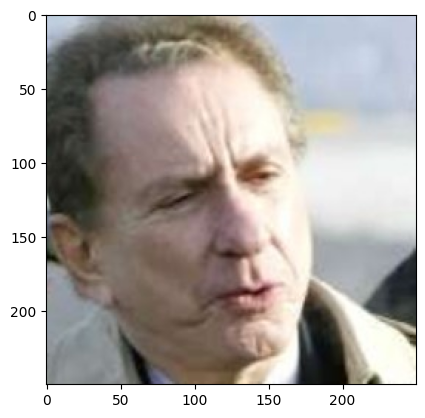

In [252]:
plt.imshow(img[:,:,::-1])

In [85]:
rotated_img, chip_rect = align_image(img)

dlib failed to find any faces, testing RetinaFace.


In [86]:
cropped_img = crop_image(rotated_img, chip_rect)

I0000 00:00:1720586275.786560   20596 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720586275.788140   24832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720586275.789353   20596 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [87]:
padded_img = pad_image(cropped_img)

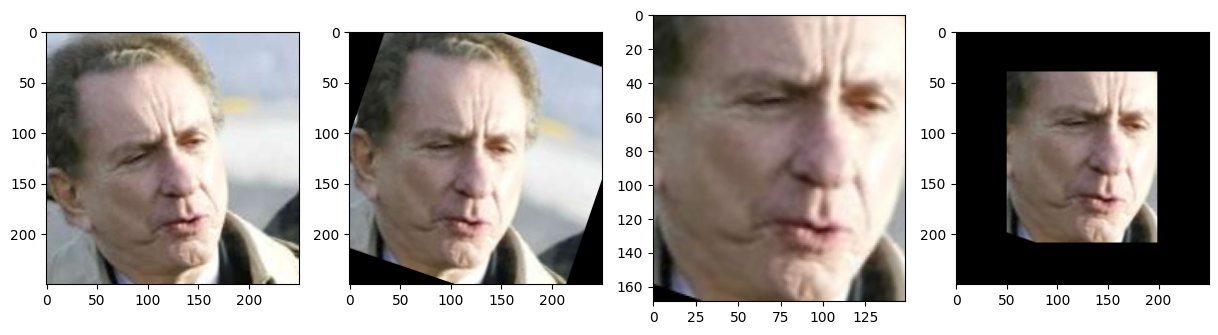

In [88]:
fig, ax = plt.subplots(1, 4, figsize = (15, 10))

ax[0].imshow(img[:, :, ::-1]);
ax[1].imshow(rotated_img[:, :, ::-1]);
ax[2].imshow(cropped_img[:, :, ::-1]);
ax[3].imshow(padded_img[:, :, ::-1]);

In [239]:
mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(static_image_mode = True,
                           max_num_faces = 1,
                           refine_landmarks = True) as face_mesh:
    results = face_mesh.process(img[:,:,::-1])

I0000 00:00:1720591702.583284   20596 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720591702.585121   27202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)


I0000 00:00:1720594097.637827   20596 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720594097.642561   28216 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)


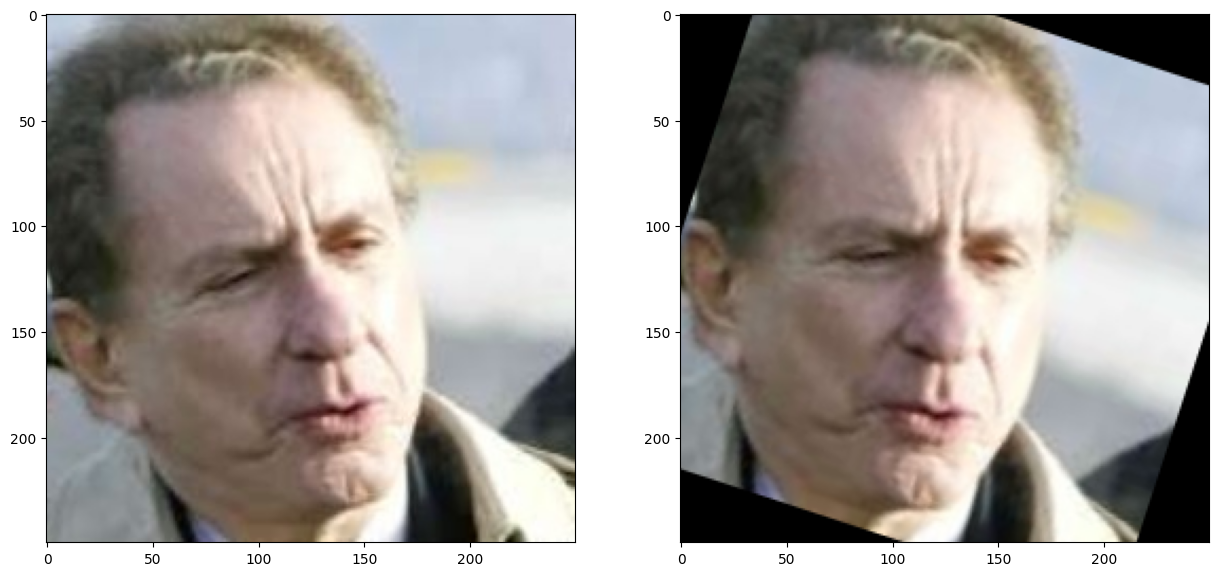

In [361]:
fig, ax = plt.subplots(1, 2, figsize = (15, 10))

mp_face_mesh = mp.solutions.face_mesh

with mp_face_mesh.FaceMesh(static_image_mode = True,
                           max_num_faces = 1,
                           refine_landmarks = True) as face_mesh:
    results = face_mesh.process(img[:,:,::-1])

rot_img = mediapipe_crop(img, results)

ax[0].imshow(img[:, :, ::-1]);
ax[1].imshow(rot_img[:, :, ::-1]);